<a href="https://colab.research.google.com/github/marcosbenicio/deep_learning_classification/blob/main/classificador_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador para os dígitos $0$ e $5$

Instalação manual de pacote

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 186 kB 49.6 MB/s 
     |████████████████████████████████| 1.2 MB 33.6 MB/s 
     |████████████████████████████████| 56 kB 2.9 MB/s 
     |████████████████████████████████| 51 kB 296 kB/s 


Bibliotecas fastai permite usar funções para rapidamente construir uma rede neuronal e treinar nosso modelo de diferenciar $0$ e $5$.

In [2]:
import fastbook
from fastai.vision.all import *
fastbook.setup_book()
from fastbook import *
import numpy as np

# Muda a escala de cor padrão da imagem para escala de cinza.
matplotlib.rc('image', cmap='Greys')

import PIL as pl
import torch as t
import pandas as pd

Mounted at /content/gdrive


Primeiro passamos o caminho do diretório prinipal MINST para a variável path. Nesse diretório temos imagens para todos os dígitos de $0$ à $9$. Em seguida, com o código (/path/...).ls( ), é possível listar o conteúdo dentro desse diretório. Temos portanto os diretórios 'training' e 'testing', e dentro de cada um deles mais outros $10$ diretórios referentes aos números de $0$ à $9$. Esse método retorna uma lista contendo os caminhos dos arquivos de imagem, onde em cada posição da lista têm armazenado o caminho para um arquivo de imagem.

Vamos também criar quatro listas com os caminhos dos arquivos em ordem crescente, usando o método sorted( ). Teremos duas listas contendo todos os caminhos das imagens de $0$s(zeros) presentes nos diretórios 'training' e 'testing', e outros duas listas para as imagens de $5$s(cincos). 

In [22]:
# Armazena o caminho para o diretório do dataset MNIST numa variável.
path = untar_data(URLs.MNIST)

# Para o diretório 'training' 
zeros_train = (path/'training'/'0').ls().sorted()
cincos_train = (path/'training'/'5').ls().sorted()

# Para o diretório 'testing' 
zeros_test = (path/'testing'/'0').ls().sorted()
cincos_test = (path/'testing'/'5').ls().sorted()

print("Caminho do MNIST: ",path)
print("\n Caminho dos diretórios testing e training: ", path.ls())
print("\nCaminho das imagens de zeros do diretório training: ", zeros_train)
print('\n')

Caminho do MNIST:  /root/.fastai/data/mnist_png

 Caminho dos diretórios testing e training:  [Path('/root/.fastai/data/mnist_png/training'), Path('/root/.fastai/data/mnist_png/testing')]

Caminho das imagens de zeros do diretório training:  [Path('/root/.fastai/data/mnist_png/training/0/1.png'), Path('/root/.fastai/data/mnist_png/training/0/1000.png'), Path('/root/.fastai/data/mnist_png/training/0/10005.png'), Path('/root/.fastai/data/mnist_png/training/0/10010.png'), Path('/root/.fastai/data/mnist_png/training/0/10022.png'), Path('/root/.fastai/data/mnist_png/training/0/10025.png'), Path('/root/.fastai/data/mnist_png/training/0/10026.png'), Path('/root/.fastai/data/mnist_png/training/0/10045.png'), Path('/root/.fastai/data/mnist_png/training/0/10069.png'), Path('/root/.fastai/data/mnist_png/training/0/10071.png'), Path('/root/.fastai/data/mnist_png/training/0/10080.png'), Path('/root/.fastai/data/mnist_png/training/0/10083.png'), Path('/root/.fastai/data/mnist_png/training/0/10107.pn

Agora criarei quatro listas contendo tensores de segunda ordem (matrizes)  de dimensão $28\times28$ representando cada uma das imagens. Portanto ficarei com duas listas contendo todas as imagens de $0$ dos diretórios 'training' e 'testing', e outras duas listas para as imagens de $5$. 

Além disso, vamos empacotar cada lista num tensor de primeira ordem (vetor) usando o método stack da biblioteca Pytorch. Irei também normalizar o tensor para os elementos do último eixo assumirem valores entre $0$ e $1$.
Para o diretório de zeros, por exemplo, o tensor que definiremos como zeros_train_tensor terá $5923$ matrizes de dimensão $28\times28$.

 

Formato do tensor de zeros do diretório training:  torch.Size([5923, 28, 28])

 Zero do diretório training: AxesSubplot(0.125,0.125;0.775x0.755)


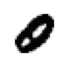

In [34]:
# Para o diretório 'training'
zeros_train_list = [tensor(Image.open(i)) for i in zeros_train]
cincos_train_list = [tensor(Image.open(i)) for i in cincos_train]

zeros_train_tensor = t.stack(zeros_train_list).float()/255
cincos_train_tensor = t.stack(cincos_train_list).float()/255

# Para o diretório 'testing'
zeros_test_list = [tensor(Image.open(i)) for i in zeros_test]
cincos_test_list = [tensor(Image.open(i)) for i in cincos_test]

zeros_test_tensor = t.stack(zeros_test_list).float()/255
cincos_test_tensor = t.stack(cincos_test_list).float()/255

print("Formato do tensor de zeros do diretório training: ", zeros_train_tensor.shape)

print("\n Zero do diretório training:", show_image(zeros_train_tensor[5]))



---



Nessas listas que definimos, as matrizes representam cada uma das imagem. Nessas matrizes estão armazenada os números das cores de cada pixel da imagem. Para ilustrar isso mostrarei a matriz que representa o número 5 do diretório training. Além disso, usarei a escala cinza para dar cor a essa matriz, onde $0$ é a cor branca, 
$255$ a cor preta e entre $0-255$ temos os tons de cinza.

In [38]:

img5_lista = cincos_train_list[6]
print(img5_lista)

df = pd.DataFrame(img5_lista[4:24,3:25])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  26,  80, 146, 146, 190, 254, 255, 116,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  61, 177, 230, 2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,80,146,146,190,254,255,116
2,0,0,0,0,0,0,0,0,0,0,0,0,61,177,230,253,253,253,253,253,253,142
3,0,0,0,0,0,0,0,0,0,88,121,222,247,253,253,253,253,220,139,34,32,5
4,0,0,0,0,0,0,0,53,151,230,253,253,253,253,243,168,92,0,0,0,0,0
5,0,0,0,0,0,0,0,93,253,253,253,253,224,117,49,0,0,0,0,0,0,0
6,0,0,0,0,0,2,93,228,253,253,253,230,51,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,111,253,253,253,253,253,253,253,108,17,0,0,0,0,0,0,0
8,0,0,0,0,5,230,253,253,253,187,114,82,235,253,86,0,0,0,0,0,0,0
9,0,0,0,0,3,194,237,135,21,5,0,0,17,239,214,31,0,0,0,0,0,0


Nossa variável independente $x$ serão as imagens $0$s e $5$s do diretório 'training' concatenanas num único tensor x_train. Para isso usarei o método view, que  muda o formato do tensor sem alterar seu conteúdo. O $-1$ é um parâmetro especial que pega o tamanho necessário de um eixo para caber todos os dados.

O tensor y_train armazenará o rótulo referente a cada imagem do tensor x_train. O método unsqueeze(1) adiciona uma dimensão ao tensor, ficando equiparável ao rank do tensor x_train. O mesmo processo vai ser feito também para o diretório 'testing', que chamarei de x_test e y_test. A isso chamamos de Dataset.

Além disso, usando a função zip podemos colocar elementos de mesmo índice e diferentes tensores como elementos de uma mesma tupla (x,y). Portanto, relacionariamos cada imagem de x_test com um rótulo de y_test através das tuplas (x,y) como um conjunto de pontos de um gráfico. Portanto as variáveis definidas como dset_train e dset_test chamamos de Dataset.


In [5]:
# Para o diretório 'training'
x_train = t.cat([zeros_train_tensor, cincos_train_tensor]).view(-1, 28*28)
y_train = tensor([0]*len(zeros_train) + [1]*len(cincos_train)).unsqueeze(1)

dset_train = list(zip(x_train, y_train))

# Para o diretório 'testing'
x_test = t.cat([zeros_test_tensor, cincos_test_tensor]).view(-1, 28*28)
y_test = tensor([0]*len(zeros_test) + [1]*len(cincos_test)).unsqueeze(1)

dset_test = list(zip(x_test, y_test))

Enquanto o Dataset armazena todos os dados de interesse em tuplas, o Dataloader é uma classe usado para iterar esses dados, gerenciar batches, e transformar dados. No nosso caso temos dois Datasets, dset_train e dset_test. Cada um deles armazenam tuplas das variáveis dependentes (rótulos $0$ e $1$ para as imagens de $0$s e de $5$s) e independes ( imagens de $0$s e $5$s representadas por tensores). Passaremos para a classe Dataloader  os Dataset para criar os objetos dl_train e dl_test.

In [6]:
dl_train = DataLoader(dset_train, batch_size=256, suffle=False)
dl_test = DataLoader(dset_test, batch_size=256, suffle=False)

Vamos inicializar um tensor usando o método randn(size) dentro da função inicia_parametros( ). Essa função recebe o número total de pixels presentes nas imagens, que no nosso caso são $28 \times 28=784$ pixels.
Usando essa função teremos 4 tensores para inicializar, 2 weights (peso) e 2 bias nomeados de w1, w2, b1, b2.



In [7]:
def inicia_parametros(num_pixel): return (t.randn(num_pixel)).requires_grad_()

w1 = inicia_parametros((28*28,30))
b1 = inicia_parametros(30)
w2 = inicia_parametros((30,1))
b2 = inicia_parametros(1)


Definimos nossa função rede_simples responsável por melhor aproximar nossos parâmetros. Ela é uma função não-linear, tendo em vista que ela é composta por equações lineares e uma não linear acoplada às demais. Usamos como função max() para acresentar essa não-linearidade da função.

Dado a possível incapacidade de da GPU  processar todo nosso x_train de uma única vez pela função rede_simples, iremos separar um batch, como se fosse um pacote menor de dados que será processado por vez.

Além disso, é definida a função mnist_loss, responsável por medir a média da distância dentre o resultado previsto e o resultado esperado do batch. Queremos verificar o quão bem conseguimos prever nossa variável dependente a partir da variável independente com uso da rede_simples.

In [8]:
def rede_simples(xb): 
    res = xb@w1 + b1    
    res = res.max(t.tensor(0.0))
    res = res@w2 + b2
    return res

batch = x_train[:4]
y_train_prev = rede_simples(batch)

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

loss = mnist_loss(y_train_prev, y_train[:4])

Nessa etapa definimos a função grad para calcular a derivada da função que definimos como rede_simples em cada ponto (x,y).


In [9]:
def grad(xb,yb, model ):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

grad(x_train[:30], y_train[:30], rede_simples)

Definimos uma função train_epoch para atualizar os parâmetros w1,w2,b1,b2. Criamos dois loops, onde no primeiro recebemos tuplas do tipo (xb,yb), retornadas pelo objeto iterativo dl_train da classe DataLoader, que são passadas para função grad para o cálculo da derivada da função rede_simples no ponto (xb,yb). No segundo loop, atualizamos os parâmetros e zeramos as derivadas para guardarmos na memória apenas a de interesse naquele instante do loop.




In [10]:
def train_epoch(model, lr, params):
    for xb,yb in dl_train:
        grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr  #decremento (taxa de aprendizado de maquina?)
            p.grad.zero_()

Vamos definir a função que vai comparar nossos resultados, nos retornando a precisão de um batch. A função sigmoid é usada para normalizar todos os valores da xb que essa função recebe, para que em seguida, possamos comparar com a variável dependente yb, criando um tensor booleano contendo False ou True. Em seguida, é retornada a média desse tensor. Essa será a precisão do modelo para um batch(=x_train[0:4]). 

Para englobar todos os batchs devemos portanto definir a função validate_epoch. Ela consiste de um loop que busca tuplas (xb,yb) do objeto Dataloader dl_test e coloca como input da função batch_accuracy. Portanto, teremos agora a precisão mais robusta do modelo para todas as batchs com essa função.

In [11]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()  
    correct = (preds>0.5) == yb
    return correct.float().mean()
    
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dl_test]
    return round(t.stack(accs).mean().item(), 4)

Por fim, podemos chamar as variáveis que usaremos e rodar o modelo. O processo de treino pode ser então observado, onde com 20 epochs obtive precisão de 98% quando comparados as imagens de 0s e 5s do diretório training com o diretório testing.

In [12]:
lr = 1
params = w1,w2,b1,b2
epochs = 20
validate_epoch(rede_simples)
for i in range(epochs):
    train_epoch(rede_simples, lr, params)
    print(validate_epoch(rede_simples), end=' ')

0.6284 0.7354 0.8174 0.8545 0.8989 0.9121 0.912 0.912 0.9262 0.9301 0.9501 0.9583 0.9627 0.9642 0.9666 0.9656 0.9671 0.9686 0.9695 0.9705 